# DC2: Generate Postage Stamps (Cutouts) for objects in the Object Catalog

Owner: **Yao-Yuan Mao** ([@yymao](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@yymao))
<br>Last Verified to Run: **2020-11-30** (by @yymao)

This notebook is partly based on the `dm_butler_postage_stamps` notebook by Michael Wood-Vasey and the Stack Club `ButlerTutorial` by Daniel Perrefort.

In this notebook, we will first obtain a list of RA, Dec positions from the Object catalog using [GCRCatalogs](https://github.com/LSSTDESC/gcr-catalogs/), and then generate "postage-stamp" cutout images from the coadded images. 

### Learning Objectives:
After working through and studying this Notebook you should be able to
   1. Find the corresponding tracts and patches for a given list of RA and Dec
   2. Generate a postage stamp from a coadd for your chosen RA, Dec in a chosen filter, using matplotlib
   3. Obtain cutout images in two different ways ( `.getCutout()` and `butler.get(bbox=..)` )   
   4. Generate false color RGB images

### Logistics
This is intended to be runnable at NERSC through the https://jupyter.nersc.gov interface from a local git clone of https://github.com/LSSTDESC/DC2-analysis in your NERSC directory.  But you can also run it wherever, with appropriate adjustment of the 'repo' location to point to a place where you have a Butler repo will all of the images. 

This notebook uses the `desc-stack-weekly-latest` kernel. Instructions for setting up the proper DESC python kernel can be found here: https://confluence.slac.stanford.edu/x/o5DVE

## Set up

First we will load the needed modules and DC2 DR6 data sets: object catalogs (with `GCRCatalogs`) and DRP products (with `desc_dc2_dm_data`).

In [1]:
# A few common packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# We will use astropy's WCS and ZScaleInterval for plotting
from astropy.wcs import WCS
from astropy.visualization import ZScaleInterval

# We will use several stack functions
import lsst.geom
import lsst.afw.display as afwDisplay
import lsst.afw.display.rgb as rgb

# And also DESC packages to get the data path
import GCRCatalogs
from GCRCatalogs.helpers.tract_catalogs import tract_filter, sample_filter
from GCRCatalogs import GCRQuery
import desc_dc2_dm_data

If you are on a custom kernel (i.e., not using a DESC kernel), and you do have stack installed, but not those DESC packages.
You can install them by uncomment and running the following cell.

In [2]:
## Uncomment and run this cell *only if* you are on a custom kernel that has stack installed, but not the DESC packages 

#%pip install https://github.com/LSSTDESC/gcr-catalogs/archive/master.zip
#%pip install https://github.com/LSSTDESC/desc-dc2-dm-data/archive/master.zip

In [3]:
sorted(desc_dc2_dm_data.REPOS)

['1.1p',
 '1.2i',
 '1.2p',
 '1.2p_v3',
 '1.2p_v4',
 '2.1i',
 '2.1i_dr1a',
 '2.1i_dr1b',
 '2.1i_dr4',
 '2.1i_v1',
 '2.2i_dia_y2_t3828',
 '2.2i_dr2',
 '2.2i_dr2_tract3828',
 '2.2i_dr2_wfd',
 '2.2i_dr3',
 '2.2i_dr6',
 '2.2i_dr6_v1',
 '2.2i_dr6_wfd',
 'dia_2020Jan']

We will be using the DC2 Run 2.2i DR6 WFD data. Read more about this data set here: https://arxiv.org/abs/2010.05926

In [4]:
dc2_data_version = "2.2i_dr6_wfd"
#dc2_data_version = "desc_dc2_run2.2i_dr6_object"

In [5]:
GCRCatalogs.get_available_catalogs(names_only=True)
#GCRCatalogs.get_public_catalog_names()

['buzzard',
 'buzzard_high-res',
 'cosmoDC2_v1.1.4_image',
 'cosmoDC2_v1.1.4_redmapper_v0.5.7',
 'cosmoDC2_v1.1.4_small',
 'dc2_object_run1.2i',
 'dc2_object_run1.2i_all_columns',
 'dc2_object_run1.2i_tract4850',
 'dc2_object_run1.2i_with_photoz',
 'dc2_object_run1.2p',
 'dc2_object_run1.2p_all_columns',
 'dc2_object_run1.2p_tract4850',
 'dc2_object_run2.2i_dr2_wfd',
 'dc2_object_run2.2i_dr2_wfd_with_addons',
 'dc2_object_run2.2i_dr3a',
 'dc2_object_run2.2i_dr3a_with_metacal',
 'dc2_object_run2.2i_dr3a_with_photoz',
 'dc2_object_run2.2i_dr6',
 'dc2_object_run2.2i_dr6_with_addons',
 'dc2_truth_run1.2_static',
 'dc2_truth_run1.2_variable_lightcurve',
 'dc2_truth_run1.2_variable_summary',
 'dc2_truth_run2.2i_galaxy_truth_summary',
 'dc2_truth_run2.2i_sn_truth_summary',
 'dc2_truth_run2.2i_sn_variability_truth',
 'dc2_truth_run2.2i_star_lc_stats',
 'dc2_truth_run2.2i_star_truth_summary',
 'dc2_truth_run2.2i_star_variability_truth',
 'dc2_truth_run2.2i_summary_tract_partition',
 'protoDC2',

In [6]:
#cat = GCRCatalogs.load_catalog("dc2_object_run"+dc2_data_version)
#cat = GCRCatalogs.load_catalog("desc_dc2_run2.2i_dr6_object")

cat = GCRCatalogs.load_catalog("dc2_object_run2.2i_dr6") # equivalent to cat = GCRCatalogs.load_catalog("desc_dc2_run2.2i_dr6_object")

In [7]:
butler = desc_dc2_dm_data.get_butler(dc2_data_version)

## Get a list of interesting objects

Here we will find some brightest galaxies in the object catalog to make cutout images for them! 

To learn what columns are in the object catalogs, refer to [this schema table](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md#schema-for-dc2-object-catalogs). And sometimes it'd be helpful to look at the [source code](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/dc2_object.py#L341).

In [8]:
# bright_galaxy_query = GCRQuery(
#     "clean",
#     "extendedness == 1",
#     "mag_r_cModel < 16",
#     "snr_g_cModel > 10",
#     "snr_r_cModel > 10",
#     "snr_i_cModel > 10",
# )

bright_galaxy_query = GCRQuery(
    "extendedness == 1",
    "mag_r_cModel < 20",
    "snr_g_cModel > 3",
    "snr_r_cModel > 3",
    "snr_i_cModel > 3",
)

In [9]:
columns_to_get = ["objectId", "ra", "dec", "mag_r_cModel", "tract", "patch"]
assert cat.has_quantities(columns_to_get)

# Here we use native_filters to limit to tract == 4639 to save some load time

# objects = cat.get_quantities(columns_to_get, filters=bright_galaxy_query, native_filters="tract == 4639")
# objects  # get_quantities returns an ordinary python dictionary

objects = cat.get_quantities(columns_to_get, filters=bright_galaxy_query, native_filters=tract_filter([3830, 3831, 4028, 4029]))
objects  # get_quantities returns an ordinary python dictionary

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.2.1/lib/python3.8/site-packages/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.2.1/lib/python3.8/site-packages/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


{'ra': array([61.11477841, 61.04976986, 61.00564096, ..., 61.93809978,
        61.82156421, 61.95438472]),
 'dec': array([-37.17771081, -37.17507316, -37.16515521, ..., -34.25538084,
        -34.22410218, -34.2153755 ]),
 'objectId': array([16844518137556835, 16844518137557779, 16844518137558346, ...,
        17720579796799876, 17720579796802274, 17720579796803393]),
 'mag_r_cModel': array([19.68727464, 19.78127856, 19.27271153, ..., 19.37942079,
        19.86731059, 19.8508436 ]),
 'patch': array(['0,0', '0,0', '0,0', ..., '6,6', '6,6', '6,6'], dtype=object),
 'tract': array([3830, 3830, 3830, ..., 4029, 4029, 4029])}

In [10]:
len(objects['mag_r_cModel'])

10106

In [11]:
# make it a pandas data frame for the ease of manipulation
objects = pd.DataFrame(objects)
objects

,ra,dec,objectId,mag_r_cModel,patch,tract
0,61.114778,-37.177711,16844518137556835,19.687275,"0,0",3830
1,61.049770,-37.175073,16844518137557779,19.781279,"0,0",3830
2,61.005641,-37.165155,16844518137558346,19.272712,"0,0",3830
3,61.155356,-37.163459,16844518137558539,19.837202,"0,0",3830
4,61.114069,-37.163552,16844518137558649,19.097313,"0,0",3830
...,...,...,...,...,...,...
10101,61.907961,-34.276914,17720579796798412,19.890256,"6,6",4029
10102,61.916910,-34.264869,17720579796799233,19.695572,"6,6",4029
10103,61.938100,-34.255381,17720579796799876,19.379421,"6,6",4029
10104,61.821564,-34.224102,17720579796802274,19.867311,"6,6",4029


We see that in the object catalog there's already tract and patch information. 

## What are tracts and patches?

The coadds produced by the DM stack are structured in terms of large `tracts` and smaller `patches`, illustrated here for DC2 Run2.2i (left panel), which covers 300 square degrees and has 165 tracts. The right panel shows a zoom-in version of the upper right corner, where you can see the patch structure. 

![DC2 Run 2 Sky Map](assets/dc2_skymap_run2.png)

### How do I find tract/patch for given RA/Dec?

What if tract/patch information were not available in the catlaog? We will then need to load the skymap, which stores such information. 

In [12]:
skymap = butler.get('deepCoadd_skyMap')

In [13]:
# find tract and patch for the 0th object: 

object_this = objects.loc[0]

radec = lsst.geom.SpherePoint(object_this["ra"], object_this["dec"], lsst.geom.degrees)
tractInfo = skymap.findTract(radec)
patchInfo = tractInfo.findPatch(radec)

print("tract =", tractInfo.getId(), "; patch =", patchInfo.getIndex())

tract = 3830 ; patch = (0, 0)


In [14]:
print(objects.keys())

print(type(tractInfo))

Index(['ra', 'dec', 'objectId', 'mag_r_cModel', 'patch', 'tract'], dtype='object')
<class 'lsst.skymap.tractInfo.ExplicitTractInfo'>


Let's now check the tract/patch values for all objects in our table are indeed consistent with what sky map tells us. 

This step is not really necessary. 
However, if you have a list of RA/Dec but not tract and patch information 
(for example, if you want to generate postage stamps for a list of galaxies from cosmoDC2),
the cell below would be useful! 

In [15]:
def get_tract_patch(ra, dec, units=lsst.geom.degrees):
    radec =  lsst.geom.SpherePoint(ra, dec, units)
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    return tractInfo.getId(), "{},{}".format(*patchInfo.getIndex())


tract_patch = objects.apply(lambda row: get_tract_patch(row["ra"], row["dec"]), axis=1, result_type='expand') \
                     .rename(columns={0: "tract", 1: "patch"})

assert (objects["tract"] == tract_patch["tract"]).all()
assert (objects["patch"] == tract_patch["patch"]).all()

tract_patch

,tract,patch
0,3830,"0,0"
1,3830,"0,0"
2,3830,"0,0"
3,3830,"0,0"
4,3830,"0,0"
...,...,...
10101,4029,"6,6"
10102,4029,"6,6"
10103,4029,"6,6"
10104,4029,"6,6"


In [16]:
type(tract_patch)

pandas.core.frame.DataFrame

In [17]:
print(objects)
print(type(objects))

print(objects.loc[0])
print(type(objects.loc[0]))

              ra        dec           objectId  mag_r_cModel patch  tract
0      61.114778 -37.177711  16844518137556835     19.687275   0,0   3830
1      61.049770 -37.175073  16844518137557779     19.781279   0,0   3830
2      61.005641 -37.165155  16844518137558346     19.272712   0,0   3830
3      61.155356 -37.163459  16844518137558539     19.837202   0,0   3830
4      61.114069 -37.163552  16844518137558649     19.097313   0,0   3830
...          ...        ...                ...           ...   ...    ...
10101  61.907961 -34.276914  17720579796798412     19.890256   6,6   4029
10102  61.916910 -34.264869  17720579796799233     19.695572   6,6   4029
10103  61.938100 -34.255381  17720579796799876     19.379421   6,6   4029
10104  61.821564 -34.224102  17720579796802274     19.867311   6,6   4029
10105  61.954385 -34.215375  17720579796803393     19.850844   6,6   4029

[10106 rows x 6 columns]
<class 'pandas.core.frame.DataFrame'>
ra                      61.114778
dec           

## Load coadd images using butler

Once we know the tract and patch, we will be able to load coadd images using butler.

In [18]:
butler.getKeys("deepCoadd")

{'filter': str, 'tract': int, 'patch': str}

In [19]:
dataId = {"tract": object_this["tract"], "patch": object_this["patch"], "filter": "i"}
print(dataId)

full_patch = butler.get("deepCoadd", dataId=dataId)

{'tract': 3830, 'patch': '0,0', 'filter': 'i'}


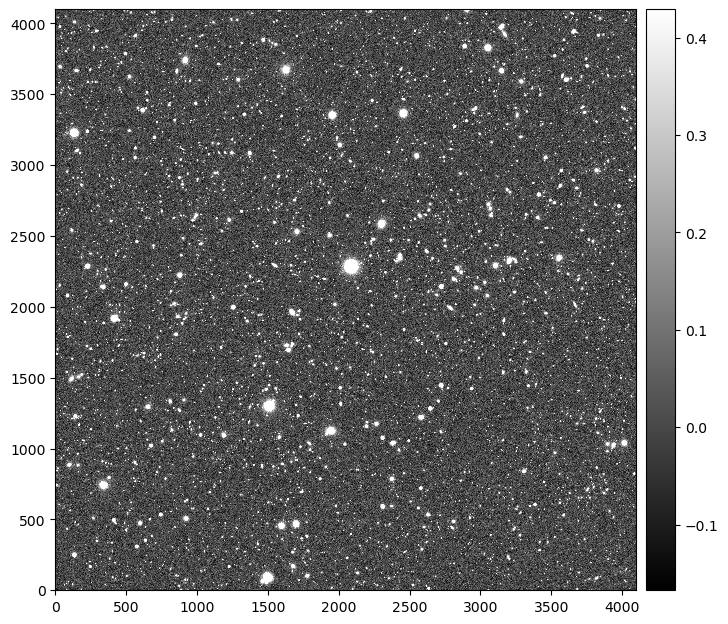

In [20]:
fig = plt.figure(figsize=(8, 8), dpi=100)
display = afwDisplay.Display(1, backend='matplotlib')
display.scale("linear", "zscale")
display.mtv(full_patch.getMaskedImage().getImage())
# Actual figure from using LSST pipeline functions

In [39]:
pixel_arr = full_patch.getMaskedImage().getImage().array
# print(pixel_arr.shape)
# print(np.max(pixel_arr))
# print(np.min(pixel_arr))

print(pixel_arr[0][0])
print(pixel_arr[1][0])
print(pixel_arr)
print(pixel_arr.shape)
print(len(pixel_arr[0]))
print(len(pixel_arr[1]))
print((pixel_arr[0][1]))

0.10063541
0.09638558
[[ 0.10063541 -0.04346023 -0.1264867  ...  0.00256038 -0.05175555
   0.18894088]
 [ 0.09638558  0.02792375  0.12345591 ...  0.02516941 -0.02682199
  -0.14860584]
 [ 0.0120674  -0.05612509  0.02105051 ... -0.0177848   0.01446696
  -0.09940898]
 ...
 [-0.02109401  0.01602534  0.00832684 ... -0.08104043 -0.01852556
   0.00726331]
 [-0.02994165  0.0307404  -0.06497734 ... -0.022695   -0.02093041
  -0.00225187]
 [ 0.07537816  0.0173849   0.05951951 ... -0.13737167 -0.09732777
  -0.11213365]]
(4100, 4100)
4100
4100
-0.043460235


(4100, 4100)
1484.9755
-0.32269067


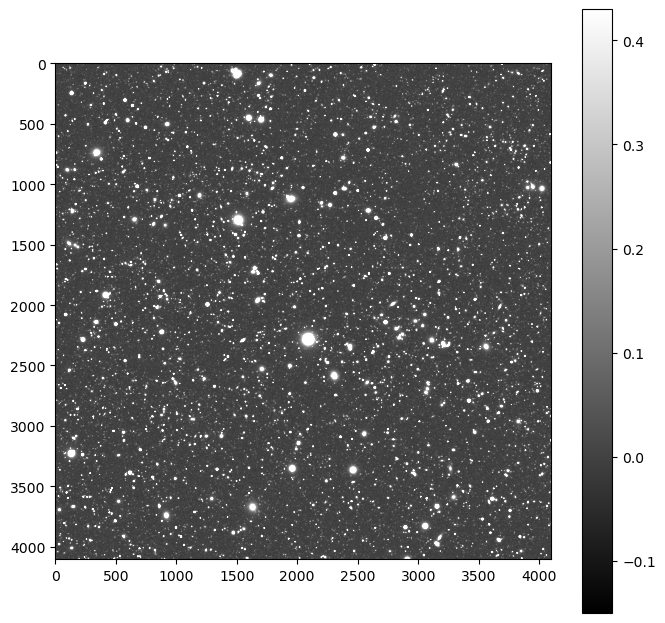

In [21]:
pixel_arr = full_patch.getMaskedImage().getImage().array
print(pixel_arr.shape)
print(np.max(pixel_arr))
print(np.min(pixel_arr))

fig = plt.figure(figsize=(8, 8), dpi=100)
ax = fig.add_subplot(111)

pos = ax.imshow(pixel_arr, vmin=-0.15, vmax=0.43, cmap='gray')
fig.colorbar(pos, ax=ax)

# This image is inverted. The two bright objects around the central bright spot @ ~ (2250,2250) are to the bottom right,
# while in the image above they're top right

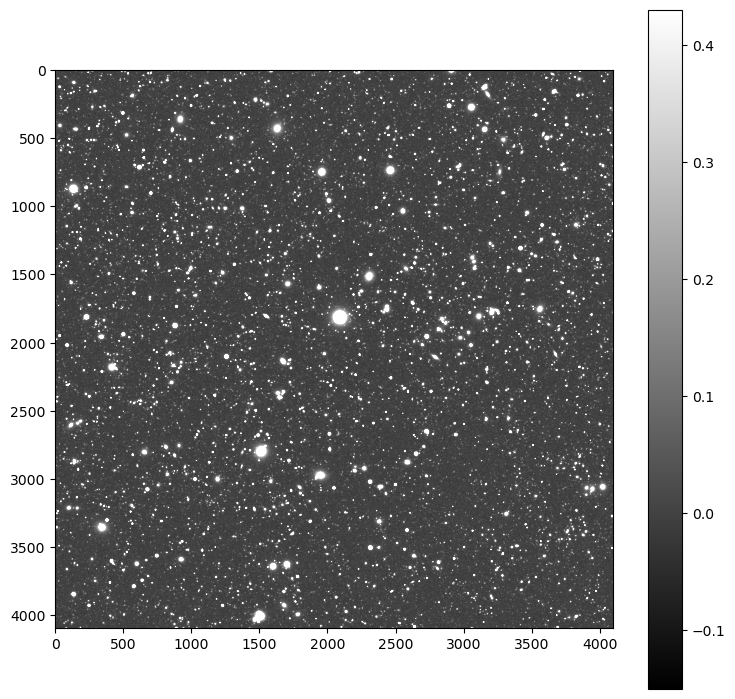

In [22]:
pixel_arr = full_patch.getMaskedImage().getImage().array

flipped_pixel_arr = np.flipud(pixel_arr) # flip ordering of column elements b/c I was getting flipped images w/o it

fig = plt.figure(figsize=(9, 9), dpi=100)
ax = fig.add_subplot(111)

pos = ax.imshow(flipped_pixel_arr, vmin=-0.15, vmax=0.43, cmap='gray')
fig.colorbar(pos, ax=ax)
# My recreation of the image below. Had to flip the order of elements in the columns to retrieve the same top right bright
# objects. Curious on (a) having the y-axis in the same order as the one from LSST & (b) why this image isn't as detailed
# as the figure in line 

# (a) I believe the ordering is just bc of the np.flipud changing the ordering, but not the actual index values

In [25]:
np.shape(pixel_arr)

(4100, 4100)

In [31]:
#plt.imshow?

In [30]:
#np.all?

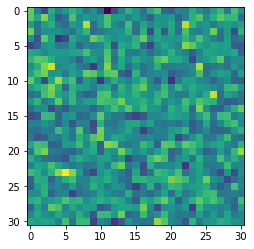

In [28]:
#print(pixel_arr[0:31])
postage_stamp_pix = pixel_arr[0:31,0:31]
#print(postage_stamp_pix)
#print(postage_stamp_pix[0])
#print(postage_stamp_pix[1])
#plt.imshow(postage_stamp_pix)
#plt.plot(full_patch.getMaskedImage().getImage())
plt.imshow(postage_stamp_pix)

In [29]:
pixel_arr = full_patch.getMaskedImage().getImage().array

x_pixels = pixel_arr

### Make a postage stamp!

To make a postage stamp, we can simply use the `getCutout` method to obtain the cutout from the full patch data. 
We can also obtain WCS information so that we can show RA/Dec values on the axes. 

Here we will use plain matplotlib to make our postage stamp, because I assume most people are more familar with matplotlib than `afw.display`! 
However, `afw.display` provides some useful functions and powerful integration with ds9 and others, if you get some time to learn it! 

In [ ]:
# Define the center and size of our cutout
radec = lsst.geom.SpherePoint(object_this["ra"], object_this["dec"], lsst.geom.degrees)
cutout_size = 32  # 300 pixels -> about 1 arcmin (we'll see why in a bit!)
cutout_extent = lsst.geom.ExtentI(cutout_size, cutout_size)

# Retrieve cutout
cutout = full_patch.getCutout(radec, cutout_extent)

# Retrieve wcs
wcs = cutout.getWcs()
print(wcs)
wcs_fits_meta = wcs.getFitsMetadata()

# Retrieve the image array
image_arr = cutout.getMaskedImage().getImage().array

In [ ]:
np.shape(image_arr)

In [ ]:
# make plot with astropy.wcs and matplotlib

fig, ax = plt.subplots(subplot_kw={'projection': WCS(wcs_fits_meta)}, figsize=(4, 4), dpi=100)

vmin, vmax = ZScaleInterval().get_limits(image_arr)
ax.imshow(image_arr, vmin=vmin, vmax=vmax, cmap='binary_r', origin='lower')

ax.set_xlabel("RA")
ax.set_ylabel("Dec")

### A different way to load cutout image by specifying a bbox

In [ ]:
center = skymap.findTract(radec).getWcs().skyToPixel(radec)
bbox = lsst.geom.BoxI(lsst.geom.Point2I((center.x - cutout_size*0.5, center.y - cutout_size*0.5)), cutout_extent)

# Note the postfix `_sub` added to the dataset type!! Note how we skip the `full_patch` step here! 
cutout = butler.get("deepCoadd_sub", dataId=dataId, bbox=bbox)

wcs_fits_meta = cutout.getWcs().getFitsMetadata()
image_arr = cutout.getMaskedImage().getImage().array

In [ ]:
# We should obtain the same image as above! 

fig, ax = plt.subplots(subplot_kw={'projection': WCS(wcs_fits_meta)}, figsize=(4, 4), dpi=100)

vmin, vmax = ZScaleInterval().get_limits(image_arr)
ax.imshow(image_arr, vmin=vmin, vmax=vmax, cmap='binary_r', origin='lower')

ax.set_xlabel("RA")
ax.set_ylabel("Dec")

With the bbox method, we can make the loading time shorter (usually 2-3x speed up). 
This is useful when you need to make many cutouts! 

In [ ]:
%%timeit
cutout = butler.get("deepCoadd", dataId=dataId).getCutout(radec, cutout_extent)

In [ ]:
%%timeit
cutout = butler.get("deepCoadd_sub", dataId=dataId, bbox=bbox)

## Make a false color RGB image

Now we have all the tools to make a false color RGB image. We will need to load in images from three bands. Here we will use g, r, and i bands. We then can use `lsst.afw.display.rgb.makeRGB` to generate the false color image.

In [ ]:
# Note how we directly supply keyword arguments instead of a single dataId dictionary here
# Also note the band ordering. We will use "irg" for "RGB", respectively. 
cutouts = [butler.get("deepCoadd_sub", bbox=bbox, tract=object_this["tract"], patch=object_this["patch"], filter=band) for band in "irg"]

wcs_fits_meta = cutouts[0].getWcs().getFitsMetadata()
image_rgb = rgb.makeRGB(*cutouts)
del cutouts  # let gc save some memory for us

fig, ax = plt.subplots(subplot_kw={'projection': WCS(wcs_fits_meta)}, figsize=(4, 4), dpi=100)
ax.imshow(image_rgb, origin='lower')
ax.set_xlabel("RA")
ax.set_ylabel("Dec")

Nice image, right? And it appears to be a blended object with a miscentering! 

## Yay! Let's put this all together now! 

This final cell is going to take a bit longer (about 50-60 seconds) 

In [ ]:
fig = plt.figure(figsize=(16, 16), dpi=100)
gs = plt.GridSpec(4, 4, fig)

cutout_size = 300
cutout_extent = lsst.geom.ExtentI(cutout_size, cutout_size)

for (_, object_this), gs_this in zip(objects.iterrows(), gs):
    radec = lsst.geom.SpherePoint(object_this["ra"], object_this["dec"], lsst.geom.degrees)
    center = skymap.findTract(radec).getWcs().skyToPixel(radec)
    bbox = lsst.geom.BoxI(lsst.geom.Point2I((center.x - cutout_size*0.5, center.y - cutout_size*0.5)), cutout_extent)

    cutouts = [butler.get("deepCoadd_sub", bbox=bbox, tract=object_this["tract"], patch=object_this["patch"], filter=band) for band in "irg"]
    wcs_fits_meta = cutouts[0].getWcs().getFitsMetadata()
    image_rgb = rgb.makeRGB(*cutouts)
    del cutouts  # let gc save some memory for us

    ax = plt.subplot(gs_this, projection=WCS(wcs_fits_meta), label=str(object_this["objectId"]))
    ax.imshow(image_rgb, origin='lower')
    del image_rgb  # let gc save some memory for us
    
    for c in ax.coords:
        c.set_ticklabel(exclude_overlapping=True, size=10)
        c.set_axislabel('', size=0)


In [ ]:
skymap = butler.get('deepCoadd_skyMap')

# find tract and patch for the 0th object: 

object_this = objects.loc[0]

radec = lsst.geom.SpherePoint(object_this["ra"], object_this["dec"], lsst.geom.degrees)
tractInfo = skymap.findTract(radec)
patchInfo = tractInfo.findPatch(radec)


In [ ]:
print(objects.loc[2])

print(radec)
print((radec))



In [ ]:
skymap = butler.get('deepCoadd_skyMap')

# find tract and patch for the 0th object: 

object_this = objects.loc[0]

radec = lsst.geom.SpherePoint(object_this["ra"], object_this["dec"], lsst.geom.degrees)
tractInfo = skymap.findTract(radec)
patchInfo = tractInfo.findPatch(radec)

In [ ]:

print("tract =", tractInfo.getId(), "; patch =", patchInfo.getIndex())

def get_tract_patch(ra, dec, units=lsst.geom.degrees):
    radec =  lsst.geom.SpherePoint(ra, dec, units)
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    return tractInfo.getId(), "{},{}".format(*patchInfo.getIndex())


tract_patch = objects.apply(lambda row: get_tract_patch(row["ra"], row["dec"]), axis=1, result_type='expand') \
                     .rename(columns={0: "tract", 1: "patch"})

assert (objects["tract"] == tract_patch["tract"]).all()
assert (objects["patch"] == tract_patch["patch"]).all()

tract_patch

butler.getKeys("deepCoadd")

# dataId = {"tract": object_this["tract"], "patch": object_this["patch"], "filter": "i"}
# print(dataId)
dataId = {"tract": object_this["tract"], "filter": "i"}
print(dataId)


full_patch = butler.get("deepCoadd", dataId=dataId)

# Let's take a look at the full patch first
fig = plt.figure(figsize=(8, 8), dpi=100)
# Note that we set frame=1 below to allow afwDisplay to use the figure instance we created
display = afwDisplay.Display(1, backend='matplotlib')
display.scale("linear", "zscale")
display.mtv(full_patch.getMaskedImage().getImage())